# The importance of Tile size: Performance of the eigensolver

To use cuSolverMg, matrices must be stored in **1D block-cyclic, column-major form**. The reason for this is to ensure that all devices participating in a specific routine can perform computations without being blocked by other parts of the computation (see Dongarra 1996). In `jaxmg`, we perform this transformation on the C++/CUDA level for you.

Choosing the tile size to be large enough is crucial for performance, as we will illustrate here. To get an idea of what the tiling looks like, consider the example where we
have a $100\times100$ matrix distributed with tile size `T_A=7` over 4 GPUS. We can plot what the tiling will look like.

(<Figure size 800x600 with 2 Axes>,
 array([<Axes: title={'center': 'Column-block sharded (shard_size=25, required padding=3)'}, xlabel='Columns', ylabel='Rows'>,
        <Axes: title={'center': '1D block-cyclic (tile size = 7)'}, xlabel='Columns', ylabel='Rows'>],
       dtype=object))

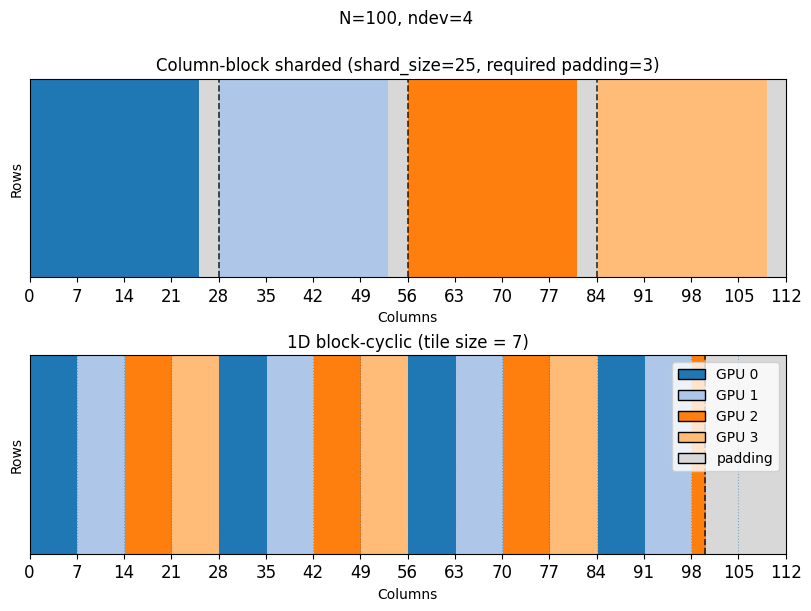

In [9]:
from jaxmg import plot_block_to_cyclic
N = 100
T_A = 7
ndev = 4
plot_block_to_cyclic(N, T_A, ndev)

Notice how we need to add extra padding to ensure that each GPU contains a number of columns that is a multiple of `T_A` (required by CusolverMg).
When matrices get larger, it is important to choose `T_A` to be large enough, since the solver will slow down otherwise. Here we explore this impact for a setup with 3 GPUs.
By increasing the tile size, we see that the performance saturates.

Devices: [CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2)]
N=2187
Status 0 - Elapsed time 11.42180[s]
Status 0 - Elapsed time 0.89933[s]
Status 0 - Elapsed time 0.77534[s]
Status 0 - Elapsed time 0.72692[s]
Status 0 - Elapsed time 0.72381[s]


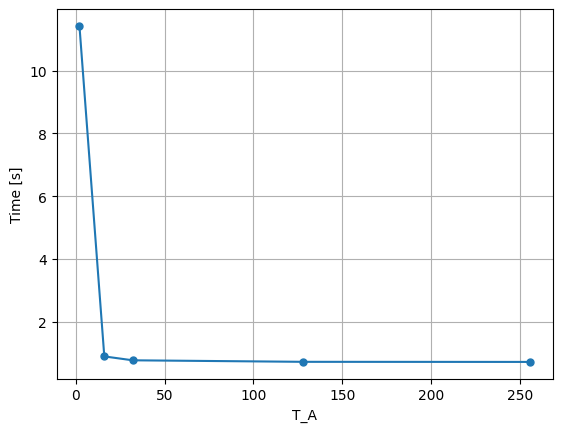

In [7]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.sharding import PartitionSpec as P, NamedSharding
from jaxmg import syevd

import matplotlib.pyplot as plt
import time

print(f"Devices: {jax.devices()}")
# Assumes we have at least one GPU available
devices = jax.devices("gpu")
N = 3**7
print(f"N={N}")
dtype = jnp.float64
# Create random 
A = jax.random.normal(key=jax.random.key(100), shape=(N,N), dtype=dtype)
A = A + A.T 
b = jnp.ones((N, 1), dtype=dtype)
ndev = len(devices)
# Make mesh and place data (rows sharded)
mesh = jax.make_mesh((ndev,), ("x",))
# Call syevd
times = []
tile_sizes = [2, 16, 32, 128, 256]
for T_A in tile_sizes:
    Adev = jax.device_put(A, NamedSharding(mesh, P("x", None))).block_until_ready()
    start = time.time()
    ev, V, status= syevd(A, T_A=T_A, mesh=mesh, in_specs=(P("x", None),), return_status=True)
    ev.block_until_ready()
    V.block_until_ready()
    end = time.time()
    times.append(end-start)
    print(f"Status {status} - Elapsed time {end - start:1.5f}[s]")
plt.plot(tile_sizes, times, marker='.', markersize=10)
plt.xlabel("T_A")
plt.ylabel("Time [s]")
plt.grid()

Notice that there is a massive slowdown for `T_A=2`. 

When we choose T_A, we want to make sure that we can equally pad each shard. For example, choosing `T_A=3**6` for a matrix of size `N=3**9` will ensure that we can pad it evenly.

(<Figure size 800x600 with 2 Axes>,
 array([<Axes: title={'center': 'Column-block sharded (shard_size=6561, required padding=0)'}, xlabel='Columns', ylabel='Rows'>,
        <Axes: title={'center': '1D block-cyclic (tile size = 729)'}, xlabel='Columns', ylabel='Rows'>],
       dtype=object))

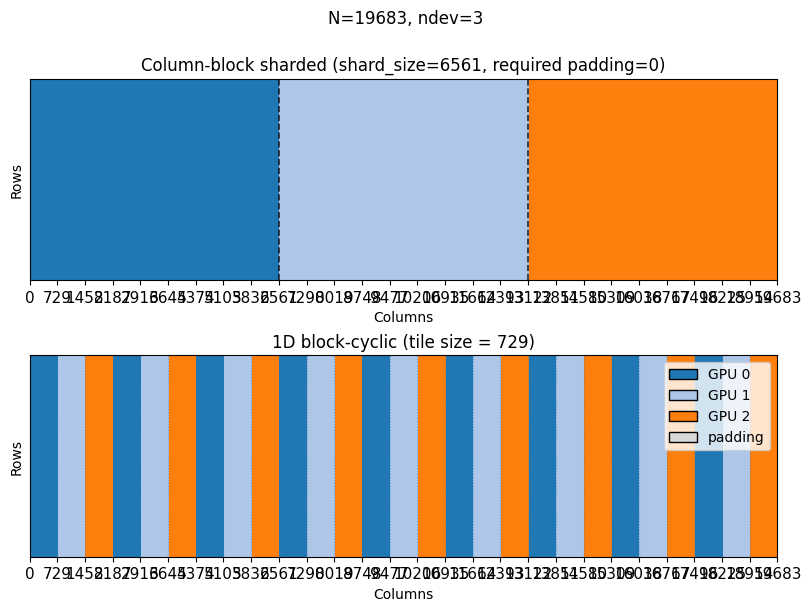

In [16]:
N = 3**9
T_A = 3**6
ndev = 3
plot_block_to_cyclic(N, T_A, ndev)

This avoids creating an additional copy of the matrix that is properly padded. 